In [1]:
%matplotlib widget
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import cm
from matplotlib.colors import Normalize
import h5py
import os
import cv2 as cv
import pandas as pd
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.animation
import matplotlib.animation as animation
from matplotlib.animation import FuncAnimation, PillowWriter, MovieWriter

### This file is for the full model, DO NOT MESS UP!!!

#### the H5 file are discribed in the README file of retina_lamina_demo (https://github.com/neurokernel/retina-lamina/tree/master/examples/retlam_demo)\
#### This is basically the rewriting of visualize_result.m 

In [2]:
# read ommatidia coordinates
elevr1 = h5py.File('retina_elev.h5', 'r')['array']
azim1 = h5py.File('retina_azim.h5', 'r')['array']
r1 = 1
y1 = -r1 * np.cos(elevr1) * np.sin(azim1)
x1 = -r1 * np.cos(elevr1) * np.cos(azim1)
z1 = r1 * np.sin(elevr1)
print(f'x1 is of the shape{np.shape(x1)}') # x1, y1, z1 is of the same dimension of ommatidiates

# read screen coordinates(or grids more precisely)
elevr2 = h5py.File('grid_dima.h5', 'r')['array']
azim2 = h5py.File('grid_dimb.h5', 'r')['array']
r2 = 10
y2 = -r2 * np.cos(elevr2) * np.sin(azim2)
x2 = -r2 * np.cos(elevr2) * np.cos(azim2)
z2 = r2 * np.sin(elevr2)
print(f'x2 is of the shape{np.shape(x2)}') # x2, y2, z2 is of the same size of input matrix, see below

x1 is of the shape(1459,)
x2 is of the shape(800, 50)


In [3]:
inputs = h5py.File('retina_input.h5', 'r')['photon']['data']
inputs = np.array(inputs)
print(np.max(inputs))
print(np.min(inputs))

inputs = inputs[::10, :] # just drop off some frames to make life easier
outputs = h5py.File('retina_output0.h5', 'r')['V']['data']
outputs = np.array(outputs)
outputs = outputs[::10, :]

R1_inputs = inputs[:, 0:-1:6] # get R1 inputs, since here there is no R7&R8
R1_outputs = outputs[:, 0:-1:6]
print('the cutted R1 in/output has shape of {}'.format(np.shape(R1_inputs)))


# intensities is the the screen input, each frame is a 800 * 50 matrix, 
# and it has steps/10 frames, due to the performance reason
screen = h5py.File('intensities.h5', 'r')['array']
print(f'the screen is of the shape {np.shape(screen)}')


87777.52241897064
0.0
the cutted R1 in/output has shape of (200, 1459)
the screen is of the shape (200, 800, 50)


In [4]:
print(np.max(inputs))
print(np.min(inputs))

87777.52241897064
0.0


In [5]:
# albers projection, see RFC3
def cartisian_to_sphere(x, y, z):
    r = np.sqrt(x**2 + y**2 + z**2)
    theta = np.arctan2(y,x)
    phi = np.arccos(z/r)
    return r, theta, phi

def albers(theta, phi):
    
    x = np.sign(np.cos(theta)) * np.sqrt((1-np.cos(phi))/(1 + np.tan(theta)**2))
    y =  x * np.tan(theta)
    return x, y

def albers_projection_cartisian(x, y, z):
    r, theta, phi = cartisian_to_sphere(x, z,-y)
    x_albers, y_albers = albers(theta, phi)
    return x_albers, y_albers


In [6]:
frame_index = 2
print(f'the min is {np.min(R1_inputs[frame_index])}')
print(f'the max is {np.max(R1_inputs[frame_index])}')


the min is 5964.667865102264
the max is 45200.387142702064


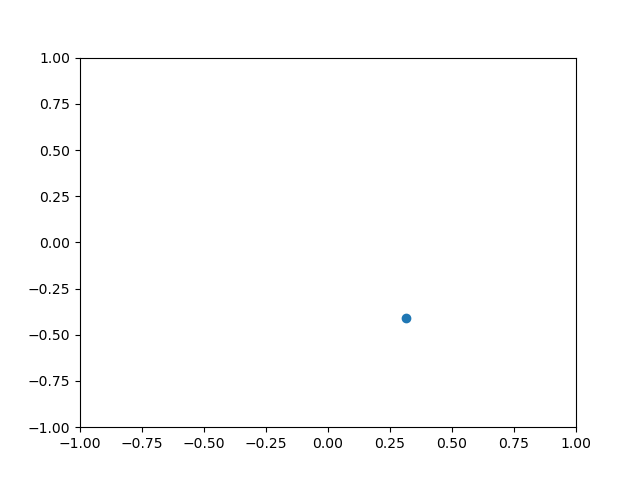

85265.00764413559
I/O is 7095.5231541603, -80.0
I/O is 7097.528935581394, -73.86760711669922
I/O is 7510.197832094709, -65.99323272705078
I/O is 7548.136244662237, -59.057064056396484
I/O is 7947.175477988884, -53.11956787109375
I/O is 8378.555530642418, -48.079689025878906
I/O is 8462.631722289509, -44.06018829345703
I/O is 9617.872042037676, -40.843849182128906
I/O is 9692.337253430129, -38.42223358154297
I/O is 10061.82127094964, -36.79973220825195
I/O is 10034.796338969722, -35.89847946166992
I/O is 10422.338865689038, -35.54823684692383
I/O is 10529.039896884025, -35.642555236816406
I/O is 11191.27360530553, -36.06512451171875
I/O is 11092.87698503591, -36.63385009765625
I/O is 11386.344624566154, -37.34569549560547
I/O is 12178.174146954876, -38.067543029785156
I/O is 12173.318773598292, -38.774658203125
I/O is 12539.47742568922, -39.46614456176758
I/O is 12536.218738397676, -40.11673355102539
I/O is 12942.313579097601, -40.71414566040039
I/O is 12942.392943655945, -41.2217712402

In [7]:
# wtf section
x2_albers, y2_albers = albers_projection_cartisian(x2, y2, z2)
x1_albers, y1_albers = albers_projection_cartisian(x1, y1, z1)

R1_index = 500
plt.scatter(x1_albers[R1_index], y1_albers[R1_index])
plt.xlim(-1, 1)
plt.ylim(-1, 1)
plt.show()
print(np.max(R1_inputs))
total_frames = np.shape(R1_inputs)[0]
for i in range(total_frames):
    print(f'I/O is {R1_inputs[i, R1_index]}, {R1_outputs[i, R1_index]}')
    

    

In [8]:
screen_input_max = np.max(screen)
screen_input_min = np.min(screen)
R1_input_max = np.max(R1_inputs)
R1_input_min = np.min(R1_inputs)
print(f'for input, the max and min is {R1_input_max} & {R1_input_min}')
R1_outputs_max_full = np.max(R1_outputs)
R1_outputs_min_full = np.min(R1_outputs)
print(f'for full model, the max and min is {R1_outputs_max_full} & {R1_outputs_min_full}')

for input, the max and min is 85265.00764413559 & 0.0
for full model, the max and min is -18.360504150390625 & -82.0


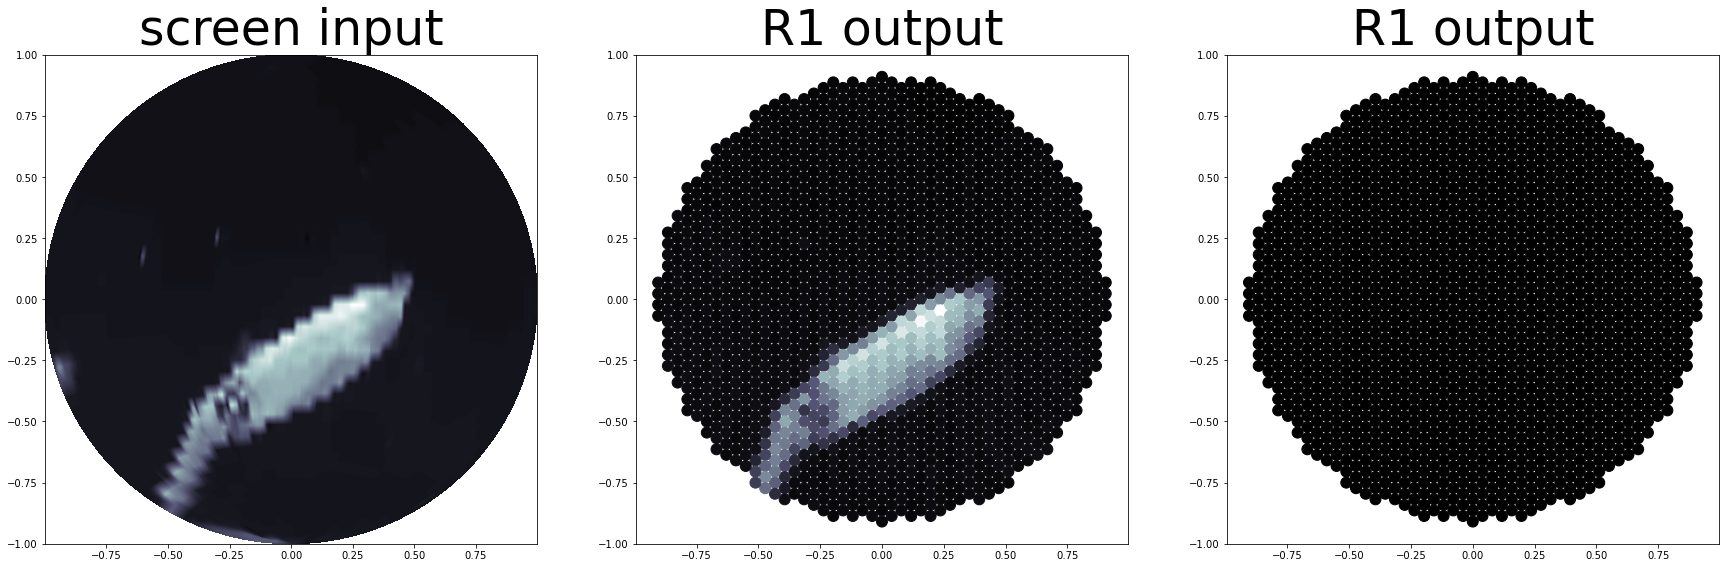

In [9]:
# I/O but with a 2d projection, single frame
# here is an example of albers projection
# sometimes the screen image may look wierd, that's because of the contourf

cool_cmap = 'bone' # just to make the plot look better...
# 'gray' is ugly
point_size = 120
x2_albers, y2_albers = albers_projection_cartisian(x2, y2, z2)
x1_albers, y1_albers = albers_projection_cartisian(x1, y1, z1)
%matplotlib inline
frame_number = 0
frame_number_R = int(frame_number/10)
frame_number_screen = int(frame_number/10)


fig = plt.figure(figsize=(30, 9))
ax_screen_input = fig.add_subplot(1, 3, 1)
C = screen[frame_number_screen,:, :]
#scalarMap = cm.ScalarMappable(norm=Normalize(vmin=C.min(), vmax=C.max()))
#C_colored = scalarMap.to_rgba(C)
# Plot the surface.
ax_screen_input.contourf(x2_albers, y2_albers, C, cmap=cool_cmap, levels=150)
ax_screen_input.set_title('screen input', fontsize=49)


ax_R1_input = fig.add_subplot(1, 3, 2)
ax_R1_input.scatter(x1_albers, y1_albers,c=R1_inputs[frame_number_R], s=point_size, cmap=cool_cmap)
ax_R1_input.set_title('R1 output', fontsize=49)

ax_R1_output = fig.add_subplot(1, 3, 3)
ax_R1_output.scatter(x1_albers, y1_albers, c=R1_outputs[frame_number_R], s=point_size, cmap=cool_cmap)
ax_R1_output.set_title('R1 output', fontsize=49)


plt.show()



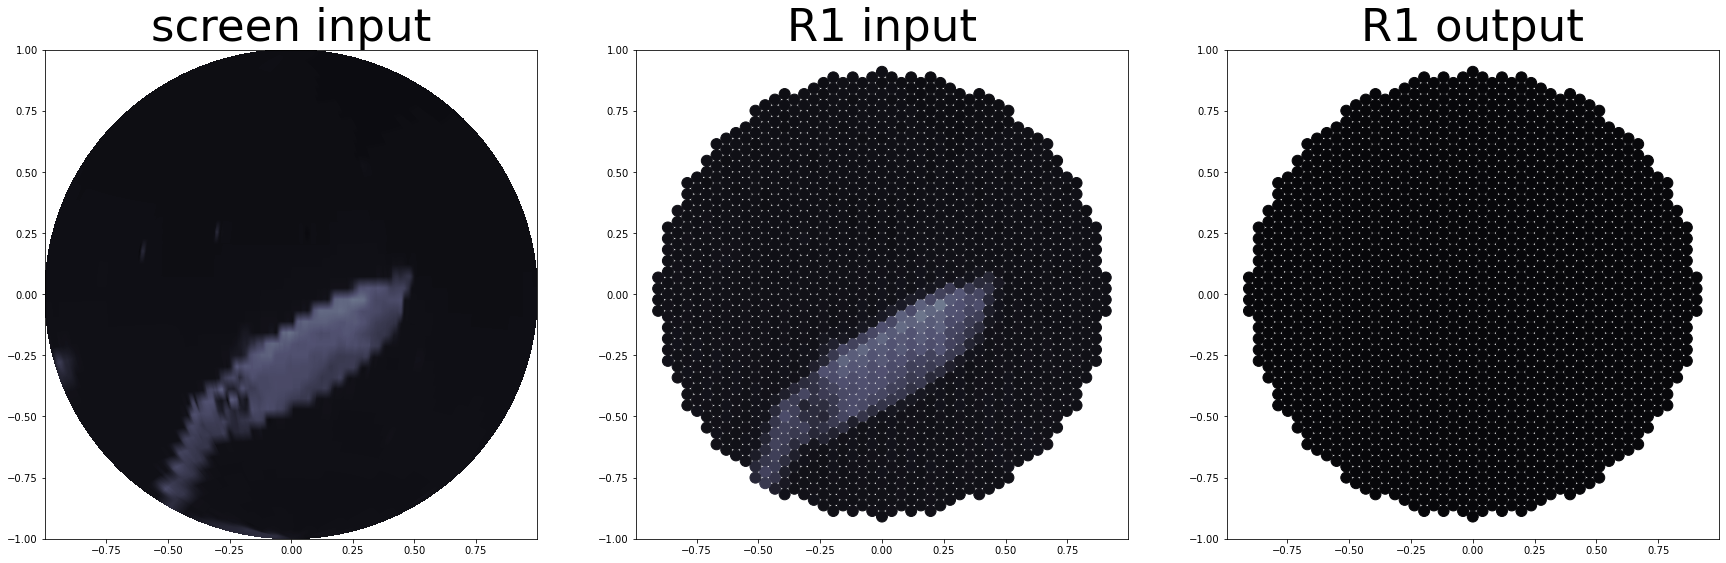

date and time = 17/09/2022 20:31:00
now is 0th frame
date and time = 17/09/2022 20:31:00
now is 0th frame
date and time = 17/09/2022 20:31:29
now is 50th frame
date and time = 17/09/2022 20:31:54
now is 100th frame
date and time = 17/09/2022 20:32:20
now is 150th frame


In [10]:
# write the video
from datetime import datetime

cool_cmap = 'bone'
point_size = 120
def update_plot(frame_number, screen, R1_inputs, R1_outputs, plot):
    #print(frame_number)
    if frame_number%50 == 0:
        now = datetime.now()
        dt_string = now.strftime("%d/%m/%Y %H:%M:%S")
        print("date and time =", dt_string)	
        print(f'now is {frame_number}th frame')
        
    for coll in ax_screen_input.collections:
        coll.remove()
    plot[1].remove()
    plot[2].remove()
    #C = screen[frame_number,:, :]
    #scalarMap = cm.ScalarMappable(norm=Normalize(vmin=C.min(), vmax=C.max()))
    #C_colored = scalarMap.to_rgba(C)
    plot[0] = ax_screen_input.contourf(x2_albers, y2_albers, screen[frame_number], 
                                       cmap=cool_cmap, levels=150, vmax=screen_input_max, vmin=screen_input_min)
    plot[1] = ax_R1_input.scatter(x1_albers, y1_albers,c=R1_inputs[frame_number], s=point_size, 
                                  cmap=cool_cmap, vmax=R1_input_max, vmin=R1_input_min)
    plot[2] = ax_R1_output.scatter(x1_albers, y1_albers, c=R1_outputs[frame_number], s=point_size, 
                                   cmap=cool_cmap, vmax=R1_outputs_max_full, vmin=R1_outputs_min_full)
    


x2_reshape = x2.reshape(-1, 1)
z2_reshape = z2.reshape(-1, 1)

x2_albers, y2_albers = albers_projection_cartisian(x2, y2, z2)
x1_albers, y1_albers = albers_projection_cartisian(x1, y1, z1)


fig = plt.figure(figsize=(30, 9))
ax_screen_input = fig.add_subplot(1, 3, 1)
ax_R1_input = fig.add_subplot(1, 3, 2 )
ax_R1_output = fig.add_subplot(1, 3, 3)



plot = [ax_screen_input.contourf(x2_albers, y2_albers, screen[0], 
                                 cmap=cool_cmap, levels=200, vmax=screen_input_max, vmin=screen_input_min),
       ax_R1_input.scatter(x1_albers, y1_albers,c=R1_inputs[0], s=point_size, 
                           cmap=cool_cmap, vmax=R1_input_max, vmin=R1_input_min),
       ax_R1_output.scatter(x1_albers, y1_albers, c=R1_outputs[0], s=point_size, 
                            cmap=cool_cmap, vmax=R1_outputs_max_full, vmin=R1_outputs_min_full)]

ax_screen_input.set_title('screen input', fontsize=45)
ax_R1_input.set_title('R1 input', fontsize=45)
ax_R1_output.set_title('R1 output', fontsize=45)


fps = 10
frn = np.shape(R1_inputs)[0]
#frn = 30
ani = animation.FuncAnimation(fig, update_plot, frn, fargs=(screen,R1_inputs, R1_outputs, plot), interval=1000/fps)

plt.show()
Writer = animation.writers['ffmpeg']
ani.save('R1_IO_full.mp4', writer=Writer(fps=10))
#ani.save('dear_all.gif', writer=PillowWriter(fps=10)) # have no idea why saving gif is soooooo slow


In [ ]:
# write the video
# with logged
from datetime import datetime

cool_cmap = 'bone'
def update_plot(frame_number, screen, R1_inputs, R1_outputs, plot):
    #print(frame_number)
    if frame_number%50 == 0:
        now = datetime.now()
        dt_string = now.strftime("%d/%m/%Y %H:%M:%S")
        print("date and time =", dt_string)	
        print(f'now is {frame_number}th frame')
        
    for coll in ax_screen_input.collections:
        coll.remove()
    plot[1].remove()
    plot[2].remove()
    plot[3].remove()
    #C = screen[frame_number,:, :]
    #scalarMap = cm.ScalarMappable(norm=Normalize(vmin=C.min(), vmax=C.max()))
    #C_colored = scalarMap.to_rgba(C)
    plot[0] = ax_screen_input.contourf(x2_albers, y2_albers, screen[frame_number], cmap=cool_cmap, levels=150)
    plot[1] = ax_R1_input.scatter(x1_albers, y1_albers,c=R1_inputs[frame_number], s=300, cmap=cool_cmap)
    plot[2] = ax_R1_input_log.scatter(x1_albers, y1_albers,c=np.log10(R1_inputs[frame_number]), s=300, cmap=cool_cmap)
    plot[3] = ax_R1_output.scatter(x1_albers, y1_albers, c=R1_outputs[frame_number], s=300, cmap=cool_cmap)
    


x2_reshape = x2.reshape(-1, 1)
z2_reshape = z2.reshape(-1, 1)

x2_albers, y2_albers = albers_projection_cartisian(x2, y2, z2)
x1_albers, y1_albers = albers_projection_cartisian(x1, y1, z1)


fig = plt.figure(figsize=(20, 20))
ax_screen_input = fig.add_subplot(2, 2, 1)
ax_R1_input = fig.add_subplot(2, 2, 2 )
ax_R1_input_log = fig.add_subplot(2, 2, 3)
ax_R1_output = fig.add_subplot(2, 2, 4 )



plot = [ax_screen_input.contourf(x2_albers, y2_albers, screen[0], cmap=cool_cmap, levels=200),
       ax_R1_input.scatter(x1_albers, y1_albers,c=R1_inputs[0], s=300, cmap=cool_cmap),
        ax_R1_input_log.scatter(x1_albers, y1_albers,c=np.log10(R1_inputs[0]), s=300, cmap=cool_cmap),
       ax_R1_output.scatter(x1_albers, y1_albers, c=R1_outputs[0], s=300, cmap=cool_cmap)]

ax_screen_input.set_title('screen input', fontsize=45)
ax_R1_input.set_title('R1 input', fontsize=45)
ax_R1_input_log.set_title('R1 input logged', fontsize=45)
ax_R1_output.set_title('R1 output', fontsize=45)


fps = 10
frn = np.shape(R1_inputs)[0]
#frn = 30
ani = animation.FuncAnimation(fig, update_plot, frn, fargs=(screen,R1_inputs, R1_outputs, plot), interval=1000/fps)

plt.show()
Writer = animation.writers['ffmpeg']
ani.save('R1_IO_2d_log.mp4', writer=Writer(fps=10))
#ani.save('dear_all.gif', writer=PillowWriter(fps=10)) # have no idea why saving gif is soooooo slow

In [ ]:
# here shows the screen input, R1 input, R1 output 
# a 3d view
# usually useless 
%matplotlib inline
frame_number = 500
frame_number_R = int(frame_number/10)
frame_number_screen = int(frame_number/10)

fig = plt.figure(figsize=(20, 20))
ax_screen_input = fig.add_subplot(1, 3, 1, projection='3d')
#ax = Axes3D(fig)
C = screen[frame_number_screen,:, :]
scalarMap = cm.ScalarMappable(norm=Normalize(vmin=C.min(), vmax=C.max()))
C_colored = scalarMap.to_rgba(C)
# Plot the surface.
surf = ax_screen_input.plot_surface(x2, y2, z2, facecolors= C_colored, cmap='gray',
                       linewidth=0, antialiased=False)
#ax_screen_input.scatter3D(x2, y2, z2, c= C_colored)
ax_screen_input.set_xlabel('X')
ax_screen_input.set_ylabel('Y')
ax_screen_input.set_zlabel('Z')
ax_screen_input.set_title('screen input')
ax_screen_input.view_init(azim=-90,  elev=0)

ax_R1_input = fig.add_subplot(1, 3, 2, projection='3d')
#print(np.shape(R1_inputs[90, :]))
ax_R1_input.scatter3D(x1, y1,z1, c=R1_inputs[frame_number_R, :])
#ax_R1_input.plot_surface(x1, y1,z1, facecolors=R1_inputs[frame_number_R, :])
ax_R1_input.set_xlabel('X')
ax_R1_input.set_ylabel('Y')
ax_R1_input.set_zlabel('Z')
ax_R1_input.set_title('R1 output')
ax_R1_input.view_init(azim=-90,  elev=0)

ax_R1_output = fig.add_subplot(1, 3, 3, projection='3d')
#print(np.shape(R1_inputs[90, :]))
ax_R1_output.scatter3D(x1, y1,z1, c=R1_outputs[frame_number_R, :])
ax_R1_output.set_xlabel('X')
ax_R1_output.set_ylabel('Y')
ax_R1_output.set_zlabel('Z')
ax_R1_output.set_title('R1 output')
ax_R1_output.view_init(azim=-90,  elev=0)


plt.show()